In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from numpy import random
from numpy.random import randn
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import kf_book.book_plots as bp
from scipy.linalg import block_diag
# read from csv and save corresponding column data to variables
# df = pd.read_csv('point1.csv')
# # transfer unit to meter
# y = df.y.div(1000)
# x = df.x.div(1000)
# # l = len(y)
# x_mean = np.mean(x)
# y_mean = np.mean(y)
process_std = 0.028
process_var = 0.028 ** 2
process_var_lateral = 0.019 **2
sensor_std = 0.077
sensor_var = 0.077 ** 2
sensor_var_lateral = 0.125 ** 2

In [3]:
# x_mean

In [4]:
# y_mean

In [31]:
# N = 4
# points = []
# hxs = []
# hys = []
# for i in range(1, N + 1):
#     df = pd.read_csv(f'hall_p{i}.csv')
#     # transfer unit to meter
#     y = df.y.div(1000)
#     x = df.x.div(1000)
#     # l = len(y)
#     x_mean = np.mean(x)
#     hxs.append(x_mean)
#     y_mean = np.mean(y)
#     hys.append(y_mean)
#     points.append([x_mean, y_mean])

# print(f"hxs: {hxs}\thys: {hys}")

hxs: [8.723759999999999, 3.6838487394957995, 4.049650684931506, 8.538613138686127]	hys: [11.424, 12.025176470588242, 1.373095890410959, 1.2489416058394163]


In [ ]:
hxs = [8.723759999999999, 3.6838487394957995, 4.049650684931506, 8.538613138686127]
hys = [11.424, 12.025176470588242, 1.373095890410959, 1.2489416058394163]

In [6]:
xs = [5.799013605442178, 5.677136752136748, 5.70306106870229, 5.09885606060606, 5.120082644628101, 4.572519379844961, 4.478495575221241, 2.03554054054054]
ys = [4.865020408163268, 4.234247863247866, 3.7864122137404563, 3.554515151515152, 3.1047024793388442, 2.931767441860464, 2.4959646017699106, 2.353558558558559]

In [7]:
from math import sin, cos, radians
# calculation of theoretical x and y for track assuming the first coordinate is correct
theo_x = [xs[0]]
theo_y = [ys[0]]

# 2nd point
theo_x.append(theo_x[-1])
theo_y.append(theo_y[-1] - 0.7)

# 3rd point
rad = radians(30)
theo_x.append(theo_x[-1] - 0.5 * sin(rad))
theo_y.append(theo_y[-1] - 0.5 * cos(rad))

# 4th point
rad = radians(30)
theo_x.append(theo_x[-1] - 0.5 * cos(rad))
theo_y.append(theo_y[-1] - 0.5 * sin(rad))

# 5th point
theo_x.append(theo_x[-1])
theo_y.append(theo_y[-1] - 0.5)

# 6th point
theo_x.append(theo_x[-1] - 0.5)
theo_y.append(theo_y[-1])

# 7th point
theo_x.append(theo_x[-1])
theo_y.append(theo_y[-1] - 0.6)

# 8th point
theo_x.append(theo_x[-1] - 2.5)
theo_y.append(theo_y[-1])

In [8]:
theo_x, theo_y

([5.799013605442178,
  5.799013605442178,
  5.549013605442178,
  5.116000903549958,
  5.116000903549958,
  4.616000903549958,
  4.616000903549958,
  2.116000903549958],
 [4.865020408163268,
  4.165020408163268,
  3.7320077062710486,
  3.4820077062710486,
  2.9820077062710486,
  2.9820077062710486,
  2.3820077062710485,
  2.3820077062710485])

In [9]:
# sample for xs and ys
sampleX = np.arange(xs[0], xs[-1], (xs[-1] - xs[0])/50).tolist()
samp_len = len(sampleX)
# samp_theoX = np.arange(theo_x[0], theo_x[-1], (theo_x[-1] - theo_x[0])/50).tolist()
samp_len

51

In [10]:
sampleX

[5.799013605442178,
 5.723744144144145,
 5.648474682846111,
 5.573205221548078,
 5.497935760250045,
 5.422666298952012,
 5.347396837653979,
 5.272127376355946,
 5.196857915057913,
 5.1215884537598795,
 5.046318992461846,
 4.971049531163813,
 4.89578006986578,
 4.820510608567747,
 4.745241147269714,
 4.669971685971681,
 4.5947022246736475,
 4.519432763375614,
 4.444163302077581,
 4.368893840779548,
 4.293624379481515,
 4.218354918183482,
 4.143085456885449,
 4.067815995587416,
 3.9925465342893824,
 3.9172770729913493,
 3.842007611693316,
 3.766738150395283,
 3.69146868909725,
 3.6161992277992168,
 3.5409297665011836,
 3.4656603052031505,
 3.3903908439051174,
 3.315121382607084,
 3.239851921309051,
 3.164582460011018,
 3.089312998712985,
 3.0140435374149517,
 2.9387740761169185,
 2.8635046148188854,
 2.7882351535208523,
 2.712965692222819,
 2.637696230924786,
 2.562426769626753,
 2.4871573083287197,
 2.4118878470306866,
 2.3366183857326535,
 2.2613489244346203,
 2.186079463136587,
 2.110

In [11]:
l = len(xs)
sampleY = []
j = 0
for i in range(l - 1):    
    k = (ys[i+1] - ys[i])/(xs[i+1] - xs[i])
    while j < samp_len and xs[i+1] <= sampleX[j] <= xs[i]:
        sampleY.append(k * (sampleX[j] - xs[i]) + ys[i])
        j += 1
#     print(f"k for measured track = {k}, the function is:\ny = {k}*(X - {xs[i]}) + {ys[i]}")

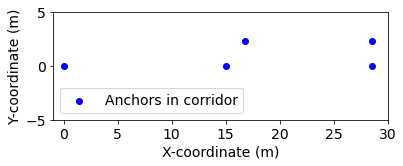

In [22]:
# corridor anchor coordinates
cx = [0, 28.547, 28.547, 15, 16.794]
cy = [0, -0.025, 2.293, 0, 2.293]
plt.rcParams.update({'font.size': 14})
plt.scatter(cx, cy, color='b', label='Anchors in corridor' )
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 30)
plt.ylim(-5, 5)
plt.xlabel("X-coordinate (m)")
plt.ylabel("Y-coordinate (m)")
plt.legend(loc='lower left')
# plt.savefig('anchors_corridor.pdf', bbox_inches='tight', dpi=400)

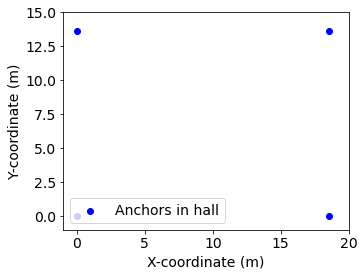

In [25]:
# hall anchor coordinates
hx = [0, 0, 18.573, 18.573]
hy = [0, 13.657, 13.657, 0]
plt.rcParams.update({'font.size': 14})
plt.scatter(cx, cy, color='b', label='Anchors in hall' )
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 20)
plt.ylim(-1, 15)
plt.xlabel("X-coordinate (m)")
plt.ylabel("Y-coordinate (m)")
plt.legend(loc='lower left')
# plt.savefig('anchors_corridor.pdf', bbox_inches='tight', dpi=400)

In [13]:
samp_lenY = len(sampleY)

In [14]:
samp_lenY

50

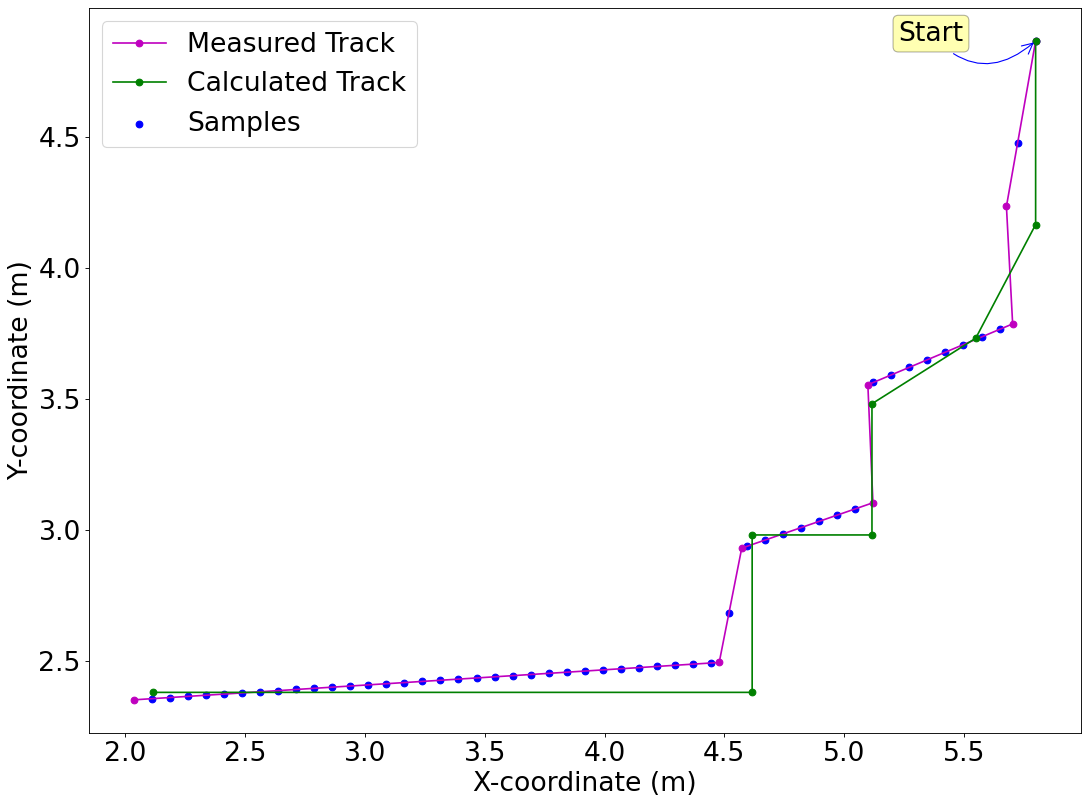

In [15]:
plt.figure(figsize=(16, 12), dpi=80)
plt.rcParams.update({'font.size': 24})
plt.xlabel("X-coordinate (m)")
plt.ylabel("Y-coordinate (m)")
plt.plot(xs, ys, '-o', color='m', label='Measured Track')
plt.plot(theo_x, theo_y, '-o', color='g', label='Calculated Track')
plt.scatter(sampleX[:samp_lenY], sampleY, color='b', label='Samples' )
plt.annotate("Start", xy=(xs[0], ys[0]), xytext=(xs[0] - 100, ys[0] - 10), textcoords='offset points', ha='center', va='bottom',color='black',
         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='blue'))
plt.legend(loc='best')
# plt.savefig('track.pdf', bbox_inches='tight', dpi=400)

In [16]:
def pf_corridor(i):
    df1 = pd.read_csv(f'corridor{i}_0707.csv')
    uwb_x1 = df1.uwb_x
    uwb_y1 = df1.uwb_y
    vel_linear_x1 = df1['vel_linear_x'].fillna(0.0)
    # first nonzero value for uwb_x
    ini_index1 = uwb_x1.ne(0).idxmax()
    def track():
        tracker = KalmanFilter(dim_x=4, dim_z=2)
        dt = 0.01
        tracker.F = np.array([[1, dt, 0,  0],
                              [0,  1, 0,  0],
                              [0,  0, 1, dt],
                              [0,  0, 0,  1]])
        tracker.u = 0.
        tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])

        tracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])
        q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
        q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)
        tracker.Q = block_diag(q_forward, q_lateral)
    #     print(f"Q = {tracker.Q}")
        tracker.x = np.array([[uwb_x1[ini_index1], vel_linear_x1[0], uwb_y1[ini_index1], 0]]).T
        tracker.P = np.eye(4) * 0.5
#         print(f"tracker.P =\n{tracker.P}")
        return tracker
    # robot circle movement
    N = len(uwb_x1[ini_index1:])
    zs1 = np.array([[uwb_x1[i], uwb_y1[i]] for i in range(ini_index1, N)])

    # run filter
    robot_tracker = track()
    # batch_filter is quite slow
    mu, cov, _, _ = robot_tracker.batch_filter(zs1[ini_index1:])

    # plot result
    plt.figure(figsize=(16, 12), dpi=80)
    plt.rcParams.update({'font.size': 24})
    # c for color in plot_filter
    plt.scatter(cx, cy, color='b', label='Anchors in corridor' )
    bp.plot_filter(mu[:, 0], mu[:, 2], c='k')
    bp.plot_measurements(zs1[ini_index1:, 0], zs1[ini_index1:, 1], color='c')
    plt.gca().set_aspect('equal', adjustable='box')
    #     plt.title('Kalman Filter position for robot movement under remote control')
    plt.xlim(-1, 30)
    plt.ylim(-5, 5)
    plt.xlabel("X-coordinate (m)")
    plt.ylabel("Y-coordinate (m)")
    # plt.annotate("Start", xy=(zs1[ini_index1][0], zs1[ini_index1][1]), xytext=(zs1[ini_index1][0] + 100, zs1[ini_index1][1] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.05', 
    #                             color='green'))
    # plt.annotate("End", xy=(zs1[-1][0], zs1[-1][1]), xytext=(zs1[-1][0] - 100, zs1[-1][1]), textcoords='offset points', ha='center', va='bottom',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
    #                             color='red'))
    # plt.plot(xs, ys, '-o', color='m', label='Measured Track')
    # plt.plot(theo_x, theo_y, '-o', color='r', label='Calculated Track')
    plt.annotate("Start", xy=(mu[0][0], mu[0][2]), xytext=(mu[0][0] - 100, mu[0][2] - 100), textcoords='offset points', ha='center', va='bottom',color='blue',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                                color='green'))
    plt.annotate("End", xy=(mu[-1][0], mu[-1][2]), xytext=(mu[-1][0], mu[-1][2] - 75), textcoords='offset points', ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
                                color='red'))
    plt.legend(loc='best')
#     plt.savefig(f"corridor{i}.pdf", bbox_inches='tight', dpi=400)

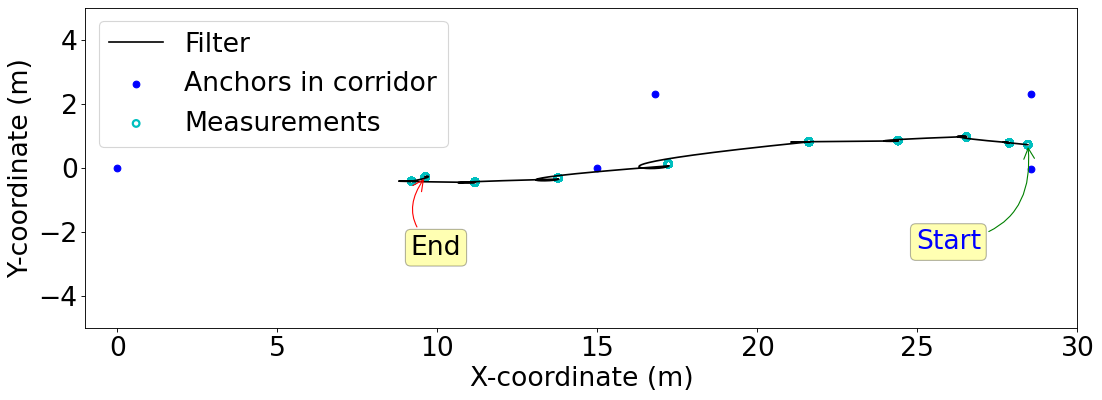

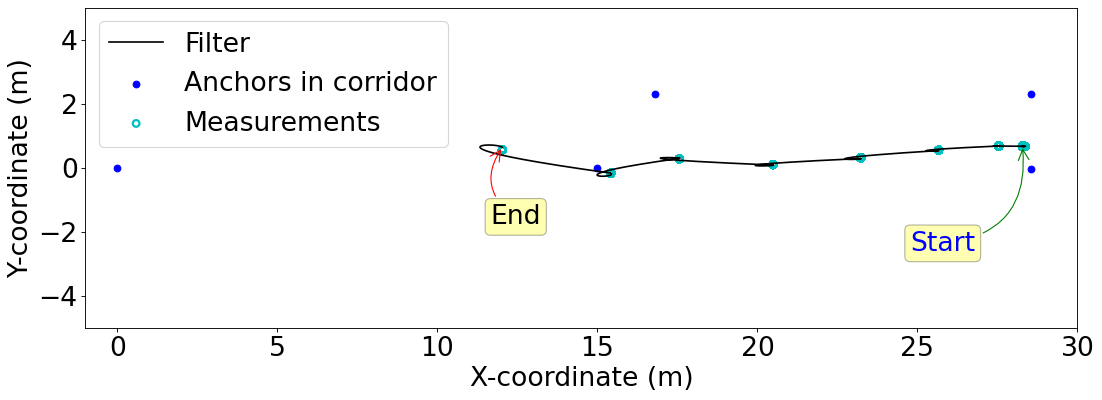

In [17]:
for i in range(1, 3):
    pf_corridor(i)

In [51]:
def kf_hall(j):
    df1 = pd.read_csv(f'hall_exp{j}.csv')
    uwb_x1 = df1['uwb/x']
    uwb_y1 = df1['uwb/y']
    vel_linear_x1 = df1['odom/vx'].fillna(0.0)
    vel_linear_y1 = df1['odom/vy'].fillna(0.0)
    # index for first nonzero value of uwb_x
    ini_index1 = uwb_x1.ne(0).idxmax()
    var_x = process_var
    var_y = process_var_lateral
    var_xvel = df1['odom/var_vx'].fillna(0.0)
    var_yvel = df1['odom/var_vy'].fillna(0.0)

    tracker = KalmanFilter(dim_x=4, dim_z=2, dim_u=2)
    dt = 0.05
    tracker.F = np.array([[1, 0, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, 0],
                          [0,  0, 0,  1]])   
    tracker.B = np.array([[dt, 0],
             [10**(-9), 0],
             [0, dt],
             [0, 10**(-9)]])
    # tracker.F = np.array([[1, 0, 0,  0],
    #                       [0,  0, 0,  0],
    #                       [0,  0, 1, 0],
    #                       [0,  0, 0, 0]])   
    # tracker.B = np.array([[dt, 0],
    #          [1, 0],
    #          [0, dt],
    #          [0, 1]])
    tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])
    tracker.R = np.array([[sensor_var*10, 0], [0, sensor_var_lateral*10]])
    q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
    q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)    
    tracker.Q = tracker.B @ np.array([[process_var*10, 0], [0, process_var_lateral*10]]) @ tracker.B.transpose()
    #     print(f"Q = {tracker.Q}")

    # robot movement
    N = len(uwb_x1[ini_index1:])
    zs1 = np.array([[uwb_x1[i], uwb_y1[i]] for i in range(ini_index1, N)])

    # run filter
    # robot_tracker = track()
    # state vector initialaization [x, vel_x, y, vel_y]
    ini_x = df1[df1['uwb/x'].notnull()]['uwb/x'][:5].mean()
    ini_y = df1[df1['uwb/y'].notnull()]['uwb/y'][:5].mean()
    tracker.x = np.array([[ini_x, vel_linear_x1[0], ini_y, vel_linear_y1[0]]]).T   
    #     P is the variance of the system
    ini_var = 10**(-9)
    tracker.P = np.array([[ini_var, 0, 0, 0],
                               [0, ini_var, 0, 0],
                               [0, 0, ini_var, 0],
                               [0, 0, 0, ini_var]])
    mu0 = []
    mu2 = []
    for i, z in enumerate(zs1):
    #     print(f"z = {z}")
    #     if not np.isnan(z[0]):
        cov_linear = np.array([[var_xvel[i], 0],
                              [0, var_yvel[i]]])
        tracker.Q = tracker.B @ cov_linear @ tracker.B.transpose()
        cmd_vel = np.array([[vel_linear_x1[i]],[vel_linear_y1[i]]])
    #     print(f"cmd_vel = {cmd_vel}")
        tracker.predict(u=cmd_vel)
        if not np.isnan(z[0]):
            tracker.update(z)
    #     print(f"tracker.x = {tracker.x}")
        mu0.append(tracker.x[0])
        mu2.append(tracker.x[2])


    # mu, cov, _, _ = robot_tracker.batch_filter(zs1[ini_index1:])
    while mu0[0] < 1 or mu2[0] < 1:
        mu0 = mu0[1:]
        mu2 = mu2[1:]
    # plot result
    plt.figure(figsize=(16, 12), dpi=80)
    plt.rcParams.update({'font.size': 24})
    # c for color in plot_filter
    bp.plot_filter(mu0, mu2, c='black')
    bp.plot_measurements(zs1[ini_index1:, 0], zs1[ini_index1:, 1], color='c')
    plt.gca().set_aspect('equal', adjustable='box')
    #     plt.title('Kalman Filter position for robot movement under remote control')
    plt.xlabel("X-coordinate (m)")
    plt.ylabel("Y-coordinate (m)")
#     plt.title(f'Sensor Fusion Plot for Hall {j}')
    # plt.annotate("Start", xy=(zs1[ini_index1][0], zs1[ini_index1][1]), xytext=(zs1[ini_index1][0] + 100, zs1[ini_index1][1] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.05', 
    #                             color='green'))
    # plt.annotate("End", xy=(zs1[-1][0], zs1[-1][1]), xytext=(zs1[-1][0] - 100, zs1[-1][1]), textcoords='offset points', ha='center', va='bottom',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
    #                             color='red'))
    plt.plot(hxs, hys, '-o', color='m', label='Measured Track')
    # plt.plot(theo_x, theo_y, '-o', color='r', label='Calculated Track')
    plt.annotate("Start", xy=(mu0[0], mu2[0]), xytext=(mu0[0] - 100, mu2[0] - 100), textcoords='offset points', ha='center', va='bottom',color='blue',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                                color='magenta'))
    plt.annotate("End", xy=(mu0[-1], mu2[-1]), xytext=(mu0[-1] - 50, mu2[-1] + 50), textcoords='offset points', ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
                                color='red'))
    plt.legend(loc='best')
#     plt.savefig(f"hall{j}.pdf", bbox_inches='tight', dpi=400)

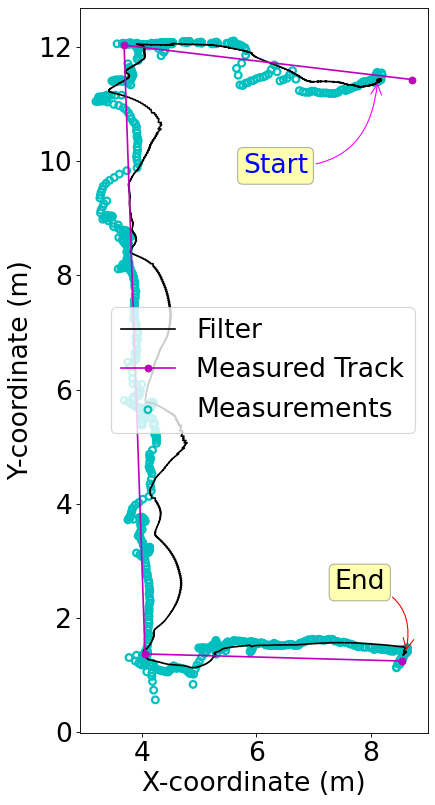

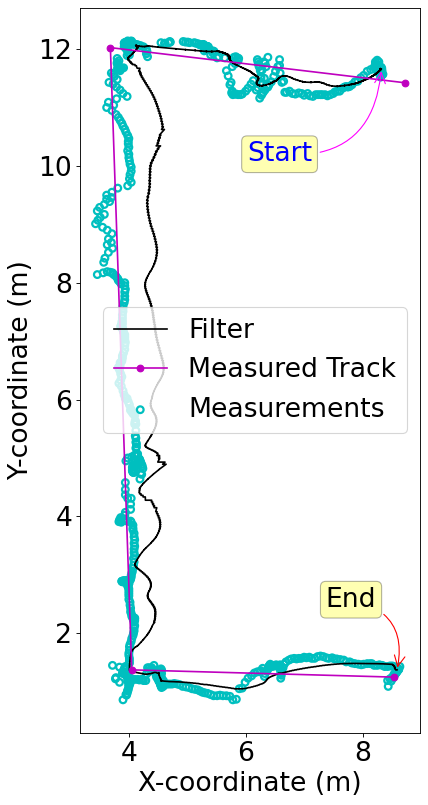

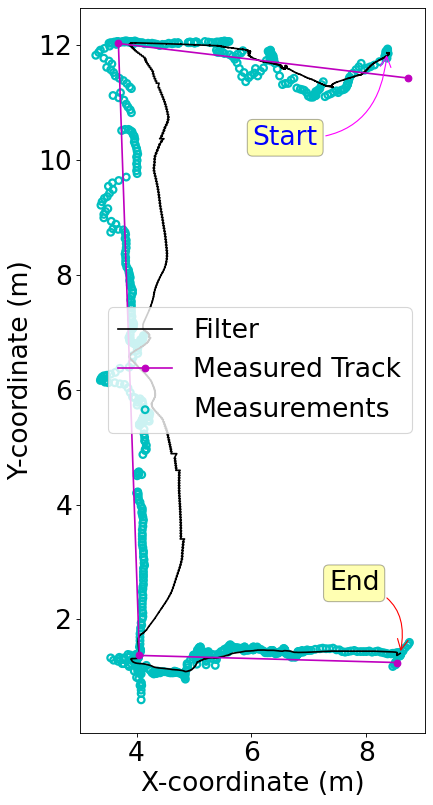

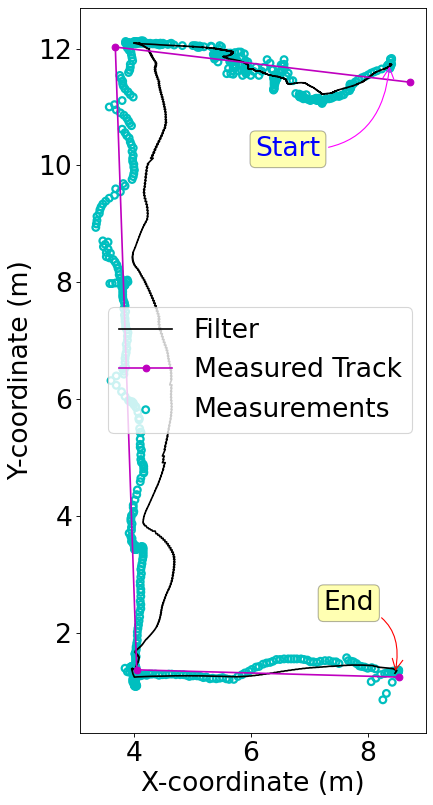

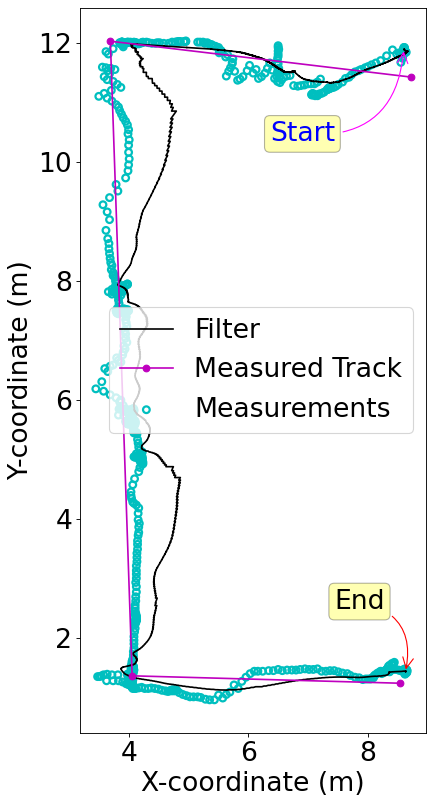

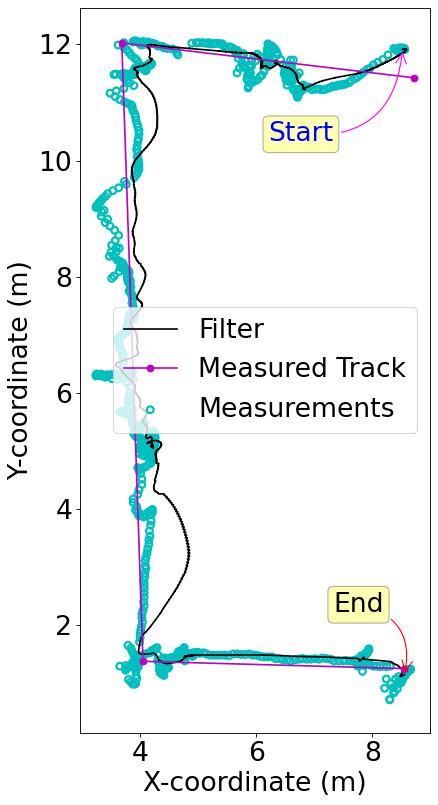

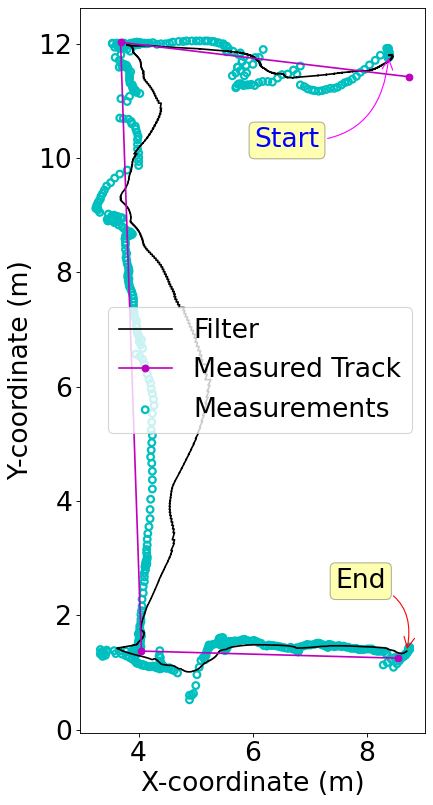

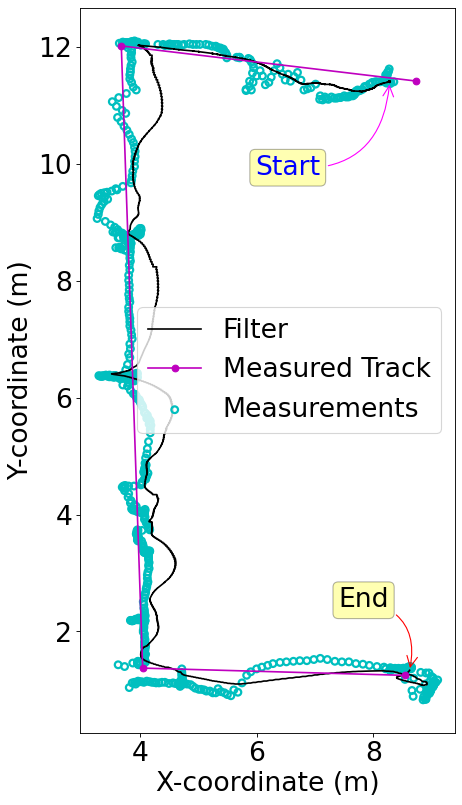

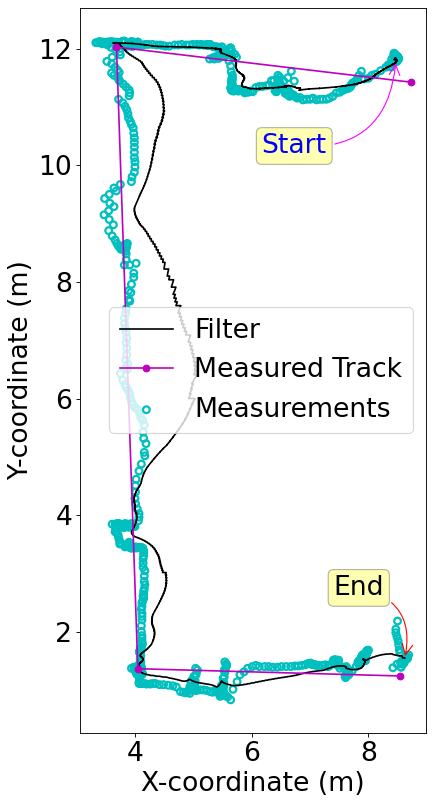

In [52]:
for i in range(1, 11):
    if i == 5:
        continue
    kf_hall(i)

In [84]:
df1

,time,la_x,la_y,uwb_x,uwb_y,vel_linear_x,vel_angular_z,mpu_ang_vel_z,mpu_linear_acc_x,mpu_linear_acc_y,...,cmd_linear_x,cmd_angular_z,var_x,var_y,var_xvel,var_yvel,vel_linear_y,odom_linear_y,odom_filtered_linear_y,cmd_linear_y
0,1.626092e+09,0.000017,-0.000001,0.00,0.00,3.236894e-07,-0.000003,NaN,NaN,NaN,...,NaN,NaN,3.891197,3.891087,0.009964,0.009964,0.0,0.000003,0.000004,NaN
1,1.626092e+09,0.000016,-0.000002,5.81,4.91,3.246793e-07,-0.000003,1.280488,0.002930,0.004883,...,NaN,NaN,3.891507,3.891398,0.008915,0.008915,0.0,0.000003,0.000004,NaN
2,1.626092e+09,0.000015,-0.000002,5.78,4.91,3.236894e-07,-0.000003,1.402439,0.002441,0.001953,...,NaN,NaN,3.892600,3.892490,0.010383,0.010383,0.0,0.000003,0.000003,NaN
3,1.626092e+09,0.000015,-0.000002,5.75,4.91,3.236894e-07,-0.000003,1.341463,0.009277,-0.002441,...,NaN,NaN,3.894078,3.893968,0.009984,0.009984,0.0,0.000002,0.000002,NaN
4,1.626092e+09,0.000014,-0.000002,5.78,4.92,3.246793e-07,-0.000003,1.280488,-0.001465,0.004395,...,NaN,NaN,3.894819,3.894709,0.009708,0.009708,0.0,0.000002,0.000001,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,1.626092e+09,-0.023683,-0.000180,1.78,2.41,9.818418e-07,-0.000009,1.341463,-0.001953,0.001953,...,0.0,0.0,4.171656,4.171492,0.010144,0.010145,0.0,0.000004,0.000001,0.0
174,1.626092e+09,-0.024976,-0.000184,1.77,2.42,9.818418e-07,-0.000009,1.280488,-0.007324,0.011719,...,0.0,0.0,4.172582,4.172419,0.009999,0.010000,0.0,0.000006,0.000005,0.0
175,1.626092e+09,-0.026071,-0.000185,1.85,2.39,9.848351e-07,-0.000009,1.402439,-0.009277,0.011719,...,0.0,0.0,4.173269,4.173105,0.010152,0.010152,0.0,0.000007,0.000007,0.0
176,1.626092e+09,-0.026959,-0.000182,1.87,2.37,9.848351e-07,-0.000009,1.280488,-0.010742,0.015625,...,0.0,0.0,4.173869,4.173706,0.008914,0.008914,0.0,0.000008,0.000009,0.0


In [85]:
def generate1(j):
    df1 = pd.read_csv(f'exp{j}_1407.csv')
    uwb_x1 = df1['uwb/x']
    uwb_y1 = df1['uwb/y']
    vel_linear_x1 = df1['odom/vx'].fillna(0.0)
    vel_linear_y1 = df1['odom/vy'].fillna(0.0)
    # index for first nonzero value of uwb_x
    ini_index1 = uwb_x1.ne(0).idxmax()
    var_x = process_var
    var_y = process_var_lateral
    var_xvel = df1['odom/var_vx'].fillna(0.0)
    var_yvel = df1['odom/var_vy'].fillna(0.0)

    tracker = KalmanFilter(dim_x=4, dim_z=2, dim_u=2)
    dt = 0.05
    tracker.F = np.array([[1, 0, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, 0],
                          [0,  0, 0,  1]])   
    tracker.B = np.array([[dt, 0],
             [10**(-9), 0],
             [0, dt],
             [0, 10**(-9)]])
    # tracker.F = np.array([[1, 0, 0,  0],
    #                       [0,  0, 0,  0],
    #                       [0,  0, 1, 0],
    #                       [0,  0, 0, 0]])   
    # tracker.B = np.array([[dt, 0],
    #          [1, 0],
    #          [0, dt],
    #          [0, 1]])
    tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])
    tracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])
    q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
    q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)    
    # tracker.Q = tracker.B @ np.array([[process_var*10, 0], [0, process_var_lateral*10]]) @ tracker.B.transpose()
    #     print(f"Q = {tracker.Q}")

    # robot movement
    N = len(uwb_x1[ini_index1:])
    zs1 = np.array([[uwb_x1[i], uwb_y1[i]] for i in range(ini_index1, N)])

    # run filter
    # robot_tracker = track()

    # state vector initialaization [x, vel_x, y, vel_y]
    ini_x = df1[df1['uwb/x'].notnull()]['uwb/x'][:5].mean()
    ini_y = df1[df1['uwb/y'].notnull()]['uwb/y'][:5].mean()
    tracker.x = np.array([[ini_x, vel_linear_x1[0], ini_y, vel_linear_y1[0]]]).T   
    #     P is the variance of the system
    ini_var = 10**(-9)
    tracker.P = np.array([[ini_var, 0, 0, 0],
                               [0, ini_var, 0, 0],
                               [0, 0, ini_var, 0],
                               [0, 0, 0, ini_var]])
    mu0 = []
    mu2 = []
    for i, z in enumerate(zs1):
    #     print(f"z = {z}")
    #     if not np.isnan(z[0]):
        cov_linear = np.array([[var_xvel[i], 0],
                              [0, var_yvel[i]]])
        tracker.Q = tracker.B @ cov_linear @ tracker.B.transpose()
        cmd_vel = np.array([[vel_linear_x1[i]],[vel_linear_y1[i]]])
    #     print(f"cmd_vel = {cmd_vel}")
        tracker.predict(u=cmd_vel)
        if not np.isnan(z[0]):
            tracker.update(z)
    #     print(f"tracker.x = {tracker.x}")
        mu0.append(tracker.x[0])
        mu2.append(tracker.x[2])

    # mu, cov, _, _ = robot_tracker.batch_filter(zs1[ini_index1:])
    while mu0[0] < 1 or mu2[0] < 1:
        mu0 = mu0[1:]
        mu2 = mu2[1:]
        
    # sample for evaluation
    for j, sx in enumerate(sampleX[:samp_lenY]):
        for k, m in enumerate(mu0):
            if abs(sx - m) <= 0.001:
                error.append(sqrt((sx - m)**2 + (sampleY[j] - mu2[k])**2))
                continue
                
    # plot result
    plt.figure(figsize=(16, 12), dpi=80)
    plt.rcParams.update({'font.size': 24})
    # c for color in plot_filter
    bp.plot_filter(mu0, mu2, c='black')
    bp.plot_measurements(zs1[ini_index1:, 0], zs1[ini_index1:, 1], color='c')
    #     plt.title('Kalman Filter position for robot movement under remote control')
    plt.xlabel("X-coordinate (m)")
    plt.ylabel("Y-coordinate (m)")
    # plt.title('Sensor Fusion Plot')
    # plt.annotate("Start", xy=(zs1[ini_index1][0], zs1[ini_index1][1]), xytext=(zs1[ini_index1][0] + 100, zs1[ini_index1][1] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.05', 
    #                             color='green'))
    # plt.annotate("End", xy=(zs1[-1][0], zs1[-1][1]), xytext=(zs1[-1][0] - 100, zs1[-1][1]), textcoords='offset points', ha='center', va='bottom',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
    #                             color='red'))
    plt.plot(xs, ys, '-o', color='m', label='Measured Track')
    plt.plot(theo_x, theo_y, '-o', color='r', label='Calculated Track')
    plt.annotate("Start", xy=(mu0[0], mu2[0]), xytext=(mu0[0] - 100, mu2[0] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                                color='magenta'))
    plt.annotate("End", xy=(mu0[-1], mu2[-1]), xytext=(mu0[-1], mu2[-1] + 50), textcoords='offset points', ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
                                color='red'))
    plt.legend(loc='best')
#     plt.show()
#     plt.savefig(f"expe{j}.pdf", bbox_inches='tight', dpi=400)

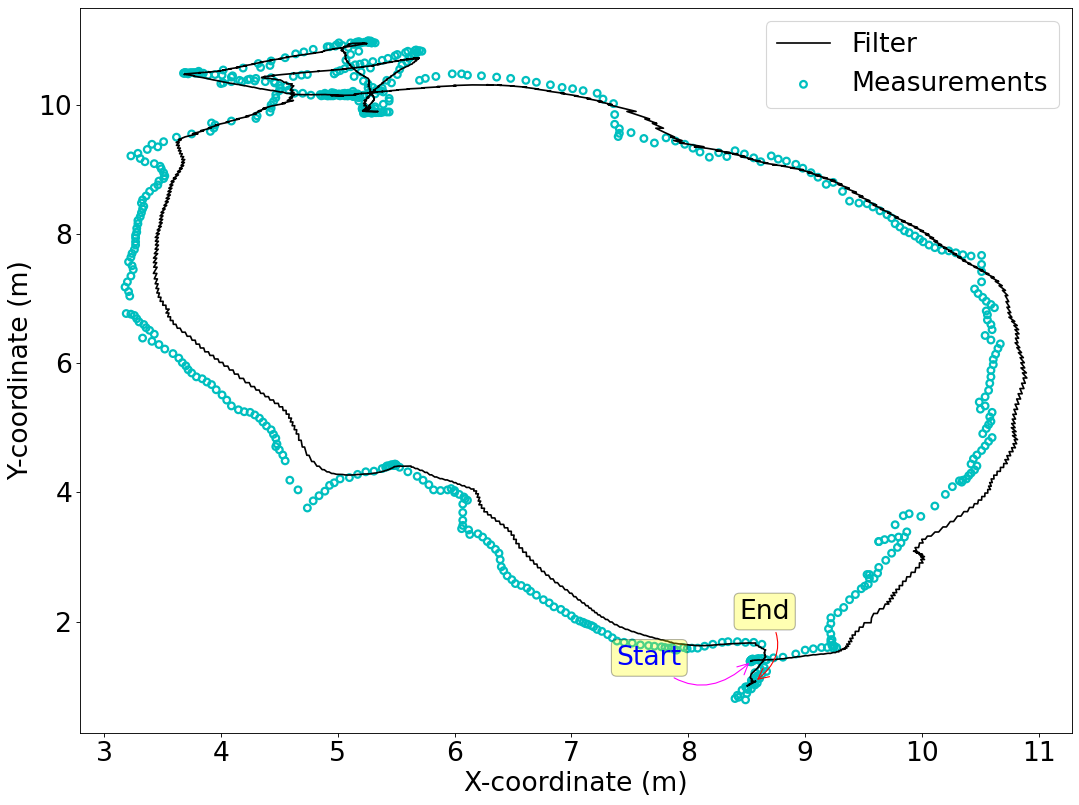

In [43]:
df1 = pd.read_csv(f'hall_random.csv')
uwb_x1 = df1['uwb/x']
uwb_y1 = df1['uwb/y']
vel_linear_x1 = df1['odom/vx'].fillna(0.0)
vel_linear_y1 = df1['odom/vy'].fillna(0.0)
# index for first nonzero value of uwb_x
ini_index1 = uwb_x1.ne(0).idxmax()
var_x = process_var
var_y = process_var_lateral
var_xvel = df1['odom/var_vx'].fillna(0.0)
var_yvel = df1['odom/var_vy'].fillna(0.0)

tracker = KalmanFilter(dim_x=4, dim_z=2, dim_u=2)
dt = 0.05
tracker.F = np.array([[1, 0, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, 0],
                      [0,  0, 0,  1]])   
tracker.B = np.array([[dt, 0],
         [10**(-9), 0],
         [0, dt],
         [0, 10**(-9)]])
# tracker.F = np.array([[1, 0, 0,  0],
#                       [0,  0, 0,  0],
#                       [0,  0, 1, 0],
#                       [0,  0, 0, 0]])   
# tracker.B = np.array([[dt, 0],
#          [1, 0],
#          [0, dt],
#          [0, 1]])
tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])
tracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])
q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)    
# tracker.Q = tracker.B @ np.array([[process_var*10, 0], [0, process_var_lateral*10]]) @ tracker.B.transpose()
#     print(f"Q = {tracker.Q}")

# robot movement
N = len(uwb_x1[ini_index1:])
zs1 = np.array([[uwb_x1[i], uwb_y1[i]] for i in range(ini_index1, N)])

# run filter
# robot_tracker = track()

# state vector initialaization [x, vel_x, y, vel_y]
ini_x = df1[df1['uwb/x'].notnull()]['uwb/x'][:5].mean()
ini_y = df1[df1['uwb/y'].notnull()]['uwb/y'][:5].mean()
tracker.x = np.array([[ini_x, vel_linear_x1[0], ini_y, vel_linear_y1[0]]]).T   
#     P is the variance of the system
ini_var = 10**(-9)
tracker.P = np.array([[ini_var, 0, 0, 0],
                           [0, ini_var, 0, 0],
                           [0, 0, ini_var, 0],
                           [0, 0, 0, ini_var]])
mu0 = []
mu2 = []
for i, z in enumerate(zs1):
#     print(f"z = {z}")
#     if not np.isnan(z[0]):
    cov_linear = np.array([[var_xvel[i], 0],
                          [0, var_yvel[i]]])
    tracker.Q = tracker.B @ cov_linear @ tracker.B.transpose()
    cmd_vel = np.array([[vel_linear_x1[i]],[vel_linear_y1[i]]])
#     print(f"cmd_vel = {cmd_vel}")
    tracker.predict(u=cmd_vel)
    if not np.isnan(z[0]):
        tracker.update(z)
#     print(f"tracker.x = {tracker.x}")
    mu0.append(tracker.x[0])
    mu2.append(tracker.x[2])

# mu, cov, _, _ = robot_tracker.batch_filter(zs1[ini_index1:])
while mu0[0] < 1 or mu2[0] < 1:
    mu0 = mu0[1:]
    mu2 = mu2[1:]

# # sample for evaluation
# for j, sx in enumerate(sampleX[:samp_lenY]):
#     for k, m in enumerate(mu0):
#         if abs(sx - m) <= 0.001:
#             error.append(sqrt((sx - m)**2 + (sampleY[j] - mu2[k])**2))
#             continue

# plot result
plt.figure(figsize=(16, 12), dpi=80)
plt.rcParams.update({'font.size': 24})
# c for color in plot_filter
bp.plot_filter(mu0, mu2, c='black')
bp.plot_measurements(zs1[ini_index1:, 0], zs1[ini_index1:, 1], color='c')
#     plt.title('Kalman Filter position for robot movement under remote control')
plt.xlabel("X-coordinate (m)")
plt.ylabel("Y-coordinate (m)")
# plt.title('Sensor Fusion Plot')
# plt.annotate("Start", xy=(zs1[ini_index1][0], zs1[ini_index1][1]), xytext=(zs1[ini_index1][0] + 100, zs1[ini_index1][1] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
#          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.05', 
#                             color='green'))
# plt.annotate("End", xy=(zs1[-1][0], zs1[-1][1]), xytext=(zs1[-1][0] - 100, zs1[-1][1]), textcoords='offset points', ha='center', va='bottom',
#          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
#          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
#                             color='red'))
# plt.plot(xs, ys, '-o', color='m', label='Measured Track')
# plt.plot(theo_x, theo_y, '-o', color='r', label='Calculated Track')
plt.annotate("Start", xy=(mu0[0], mu2[0]), xytext=(mu0[0] - 100, mu2[0] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='magenta'))
plt.annotate("End", xy=(mu0[-1], mu2[-1]), xytext=(mu0[-1], mu2[-1] + 50), textcoords='offset points', ha='center', va='bottom',
         bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
                            color='red'))
plt.legend(loc='best')
#     plt.show()
# plt.savefig(f"hall_oval.pdf", bbox_inches='tight', dpi=400)

In [87]:
from math import sqrt
error = []
for j, sx in enumerate(sampleX):
    for i, m in enumerate(mu[:, 0]):
        if abs(sx - m) <= 0.001:
            error.append(sqrt((sx - m)**2 + (sampleY[j] - mu[:, 2][i])**2))
            continue

NameError: name 'mu' is not defined

In [ ]:
err_len = len(error)
err_len

In [ ]:
np.mean(error)

In [90]:
import statistics
statistics.mean(error)

0.2780208156858064

In [ ]:
statistics.variance(error)

In [ ]:
def generate(i):
    df1 = pd.read_csv(f'exp{i}_2506.csv')
    uwb_x1 = df1.uwb_x
    uwb_y1 = df1.uwb_y
    vel_linear_x1 = df1['vel_linear_x'].fillna(0.0)
    # first nonzero value for uwb_x
    ini_index1 = uwb_x1.ne(0).idxmax()
    def track():
        tracker = KalmanFilter(dim_x=4, dim_z=2)
        dt = 0.01
        tracker.F = np.array([[1, dt, 0,  0],
                              [0,  1, 0,  0],
                              [0,  0, 1, dt],
                              [0,  0, 0,  1]])
        tracker.u = 0.
        tracker.H = np.array([[1., 0., 0., 0], [0., 0., 1., 0.]])

        tracker.R = np.array([[sensor_var, 0], [0, sensor_var_lateral]])
        q_forward = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
        q_lateral = Q_discrete_white_noise(dim=2, dt=dt, var=process_var_lateral)
        tracker.Q = block_diag(q_forward, q_lateral)
    #     print(f"Q = {tracker.Q}")
        tracker.x = np.array([[uwb_x1[ini_index1], vel_linear_x1[0], uwb_y1[ini_index1], 0]]).T
        tracker.P = np.eye(4) * 0.5
        return tracker
    # robot circle movement
    N = len(uwb_x1[ini_index1:])
    zs1 = np.array([[uwb_x1[i], uwb_y1[i]] for i in range(ini_index1, N)])

    # run filter
    robot_tracker = track()
    # batch_filter is quite slow
    mu, cov, _, _ = robot_tracker.batch_filter(zs1[ini_index1:])

    # sample for evaluation
    for j, sx in enumerate(sampleX[:samp_lenY]):
        for k, m in enumerate(mu[:, 0]):
            if abs(sx - m) <= 0.001:
                error.append(sqrt((sx - m)**2 + (sampleY[j] - mu[:, 2][k])**2))
                continue
    
    # plot result
    plt.figure(figsize=(16, 12), dpi=80)
    plt.rcParams.update({'font.size': 24})
    # c for color in plot_filter
    bp.plot_filter(mu[:, 0], mu[:, 2], c='k')
    bp.plot_measurements(zs1[ini_index1:, 0], zs1[ini_index1:, 1], color='c')
#     plt.title('Kalman Filter position for robot movement under remote control')
    plt.xlabel("X-coordinate (m)")
    plt.ylabel("Y-coordinate (m)")
    # plt.annotate("Start", xy=(zs1[ini_index1][0], zs1[ini_index1][1]), xytext=(zs1[ini_index1][0] + 100, zs1[ini_index1][1] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.05', 
    #                             color='green'))
    # plt.annotate("End", xy=(zs1[-1][0], zs1[-1][1]), xytext=(zs1[-1][0] - 100, zs1[-1][1]), textcoords='offset points', ha='center', va='bottom',
    #          bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
    #          arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
    #                             color='red'))
    plt.plot(xs, ys, '-o', color='m', label='Measured Track')
    plt.plot(theo_x, theo_y, '-o', color='r', label='Calculated Track')
    plt.annotate("Start", xy=(mu[0][0], mu[0][2]), xytext=(mu[0][0] - 100, mu[0][2] - 10), textcoords='offset points', ha='center', va='bottom',color='blue',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                                color='green'))
    plt.annotate("End", xy=(mu[-1][0], mu[-1][2]), xytext=(mu[-1][0], mu[-1][2] + 50), textcoords='offset points', ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
                                color='red'))
    plt.legend(loc='best')
#     plt.savefig(f"exp{i}.pdf", bbox_inches='tight', dpi=400)

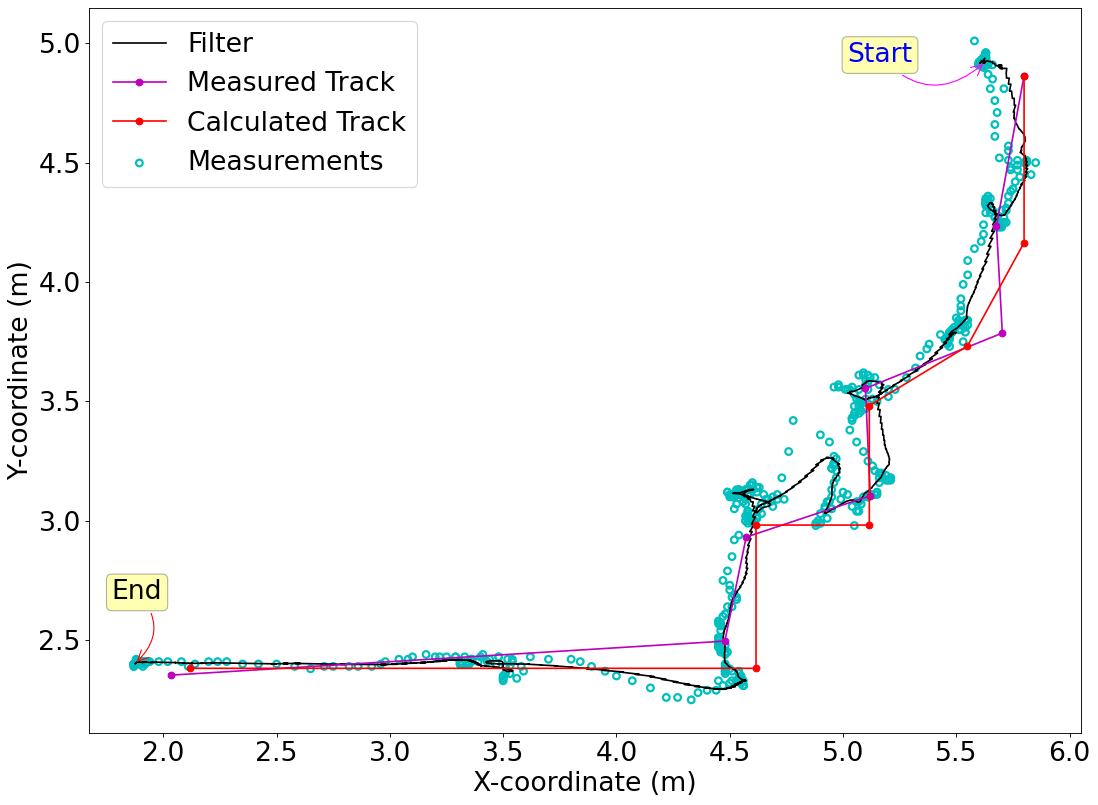

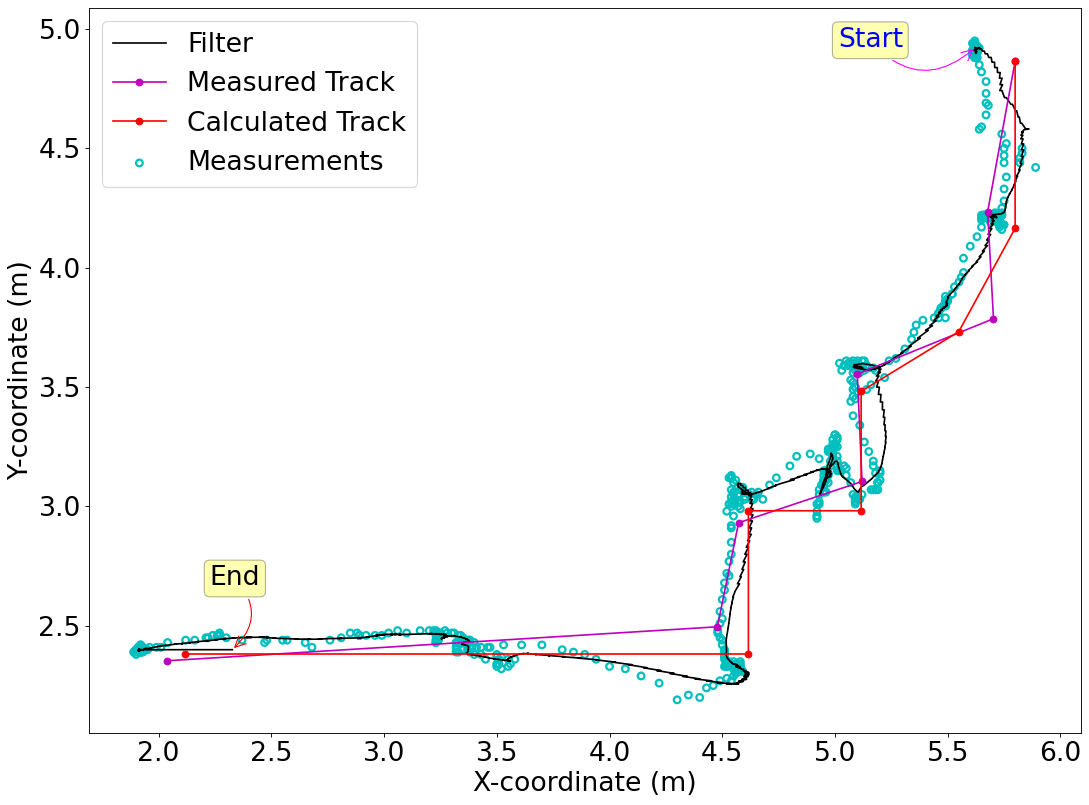

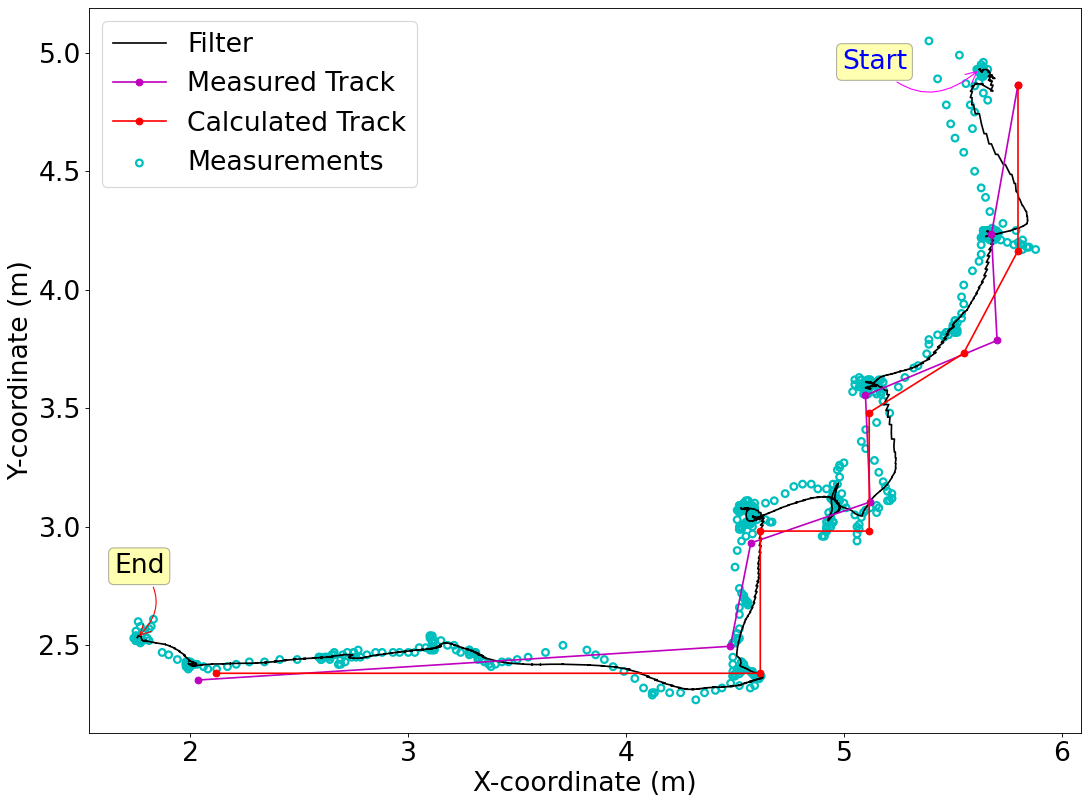

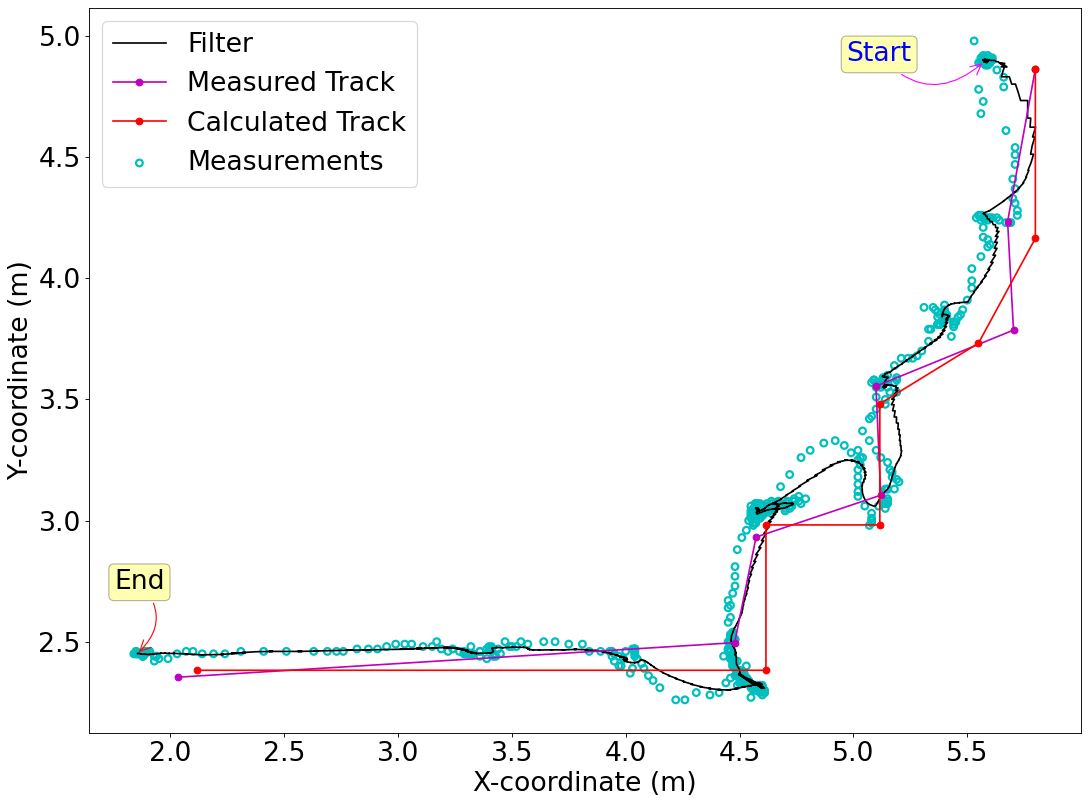

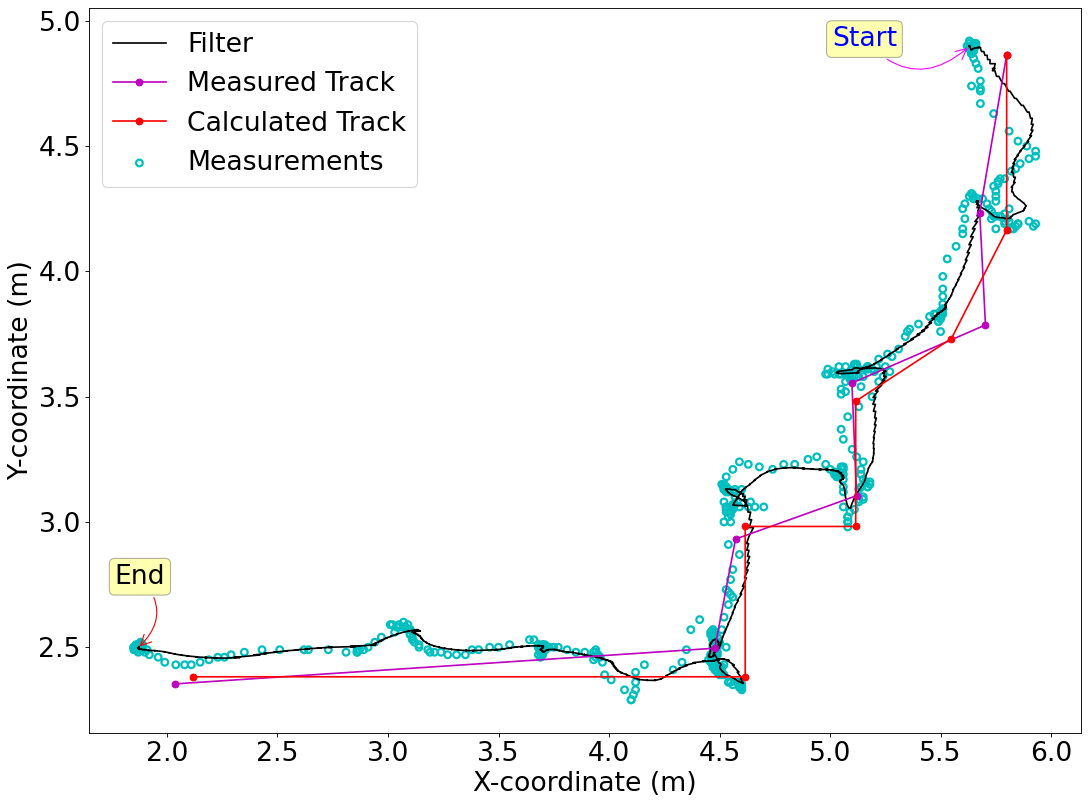

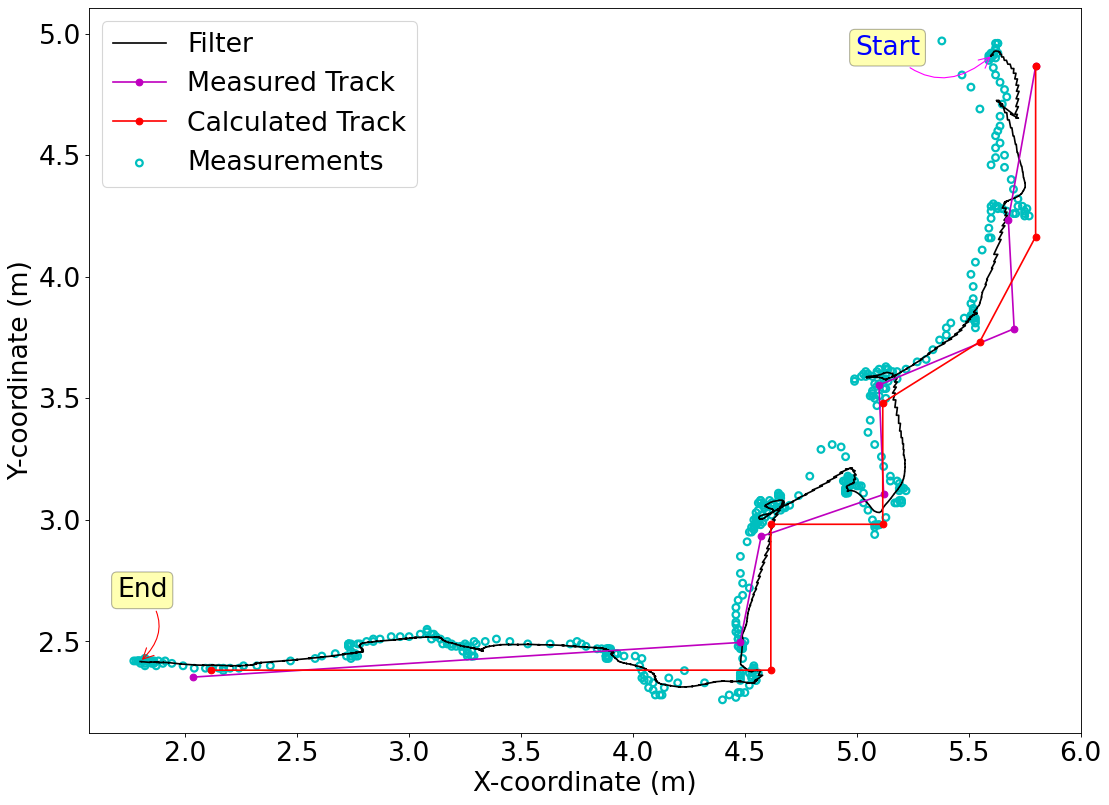

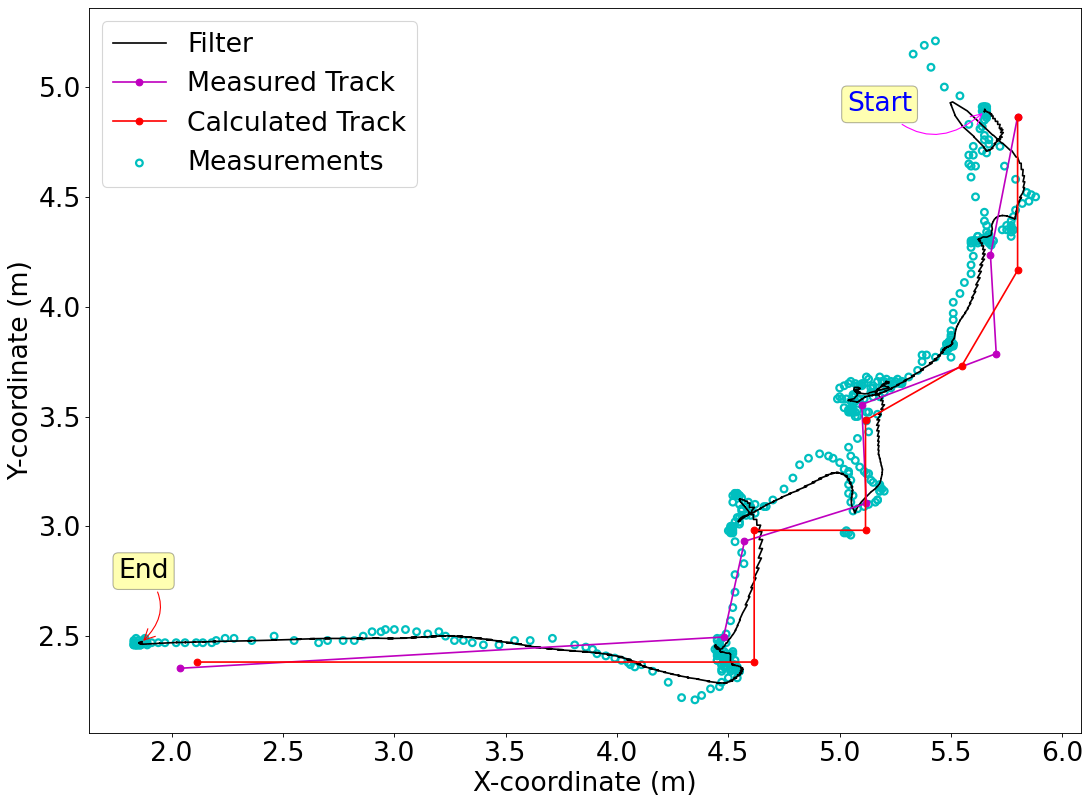

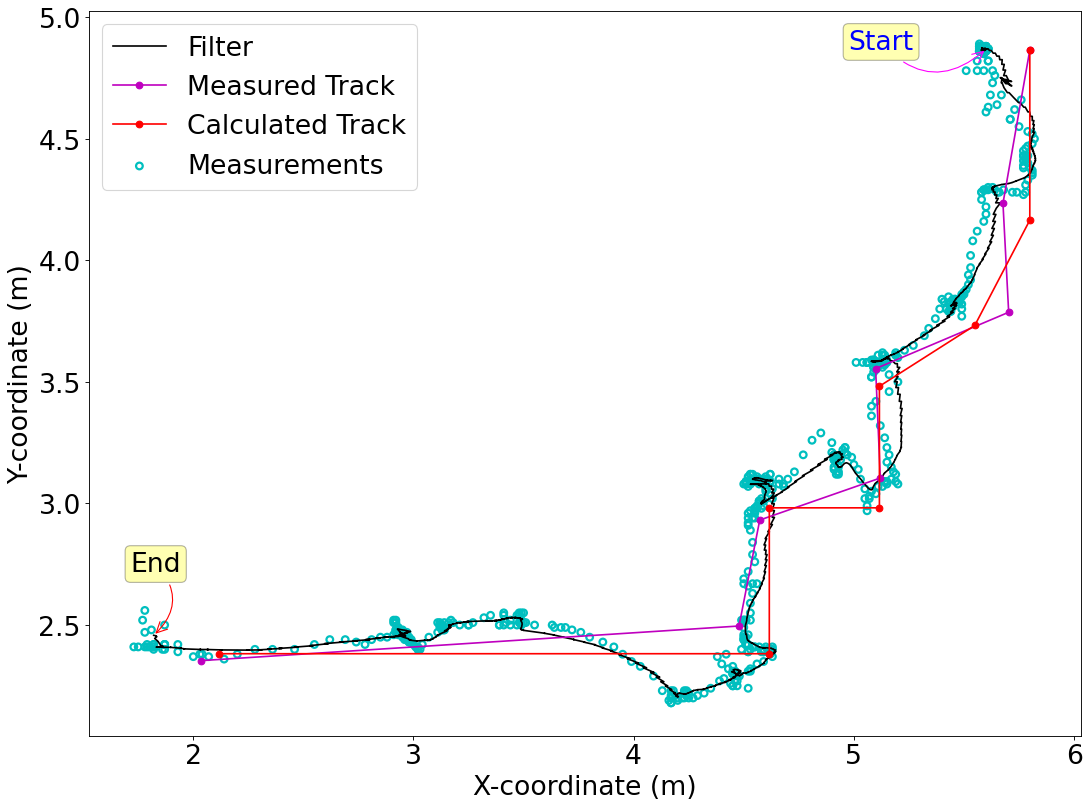

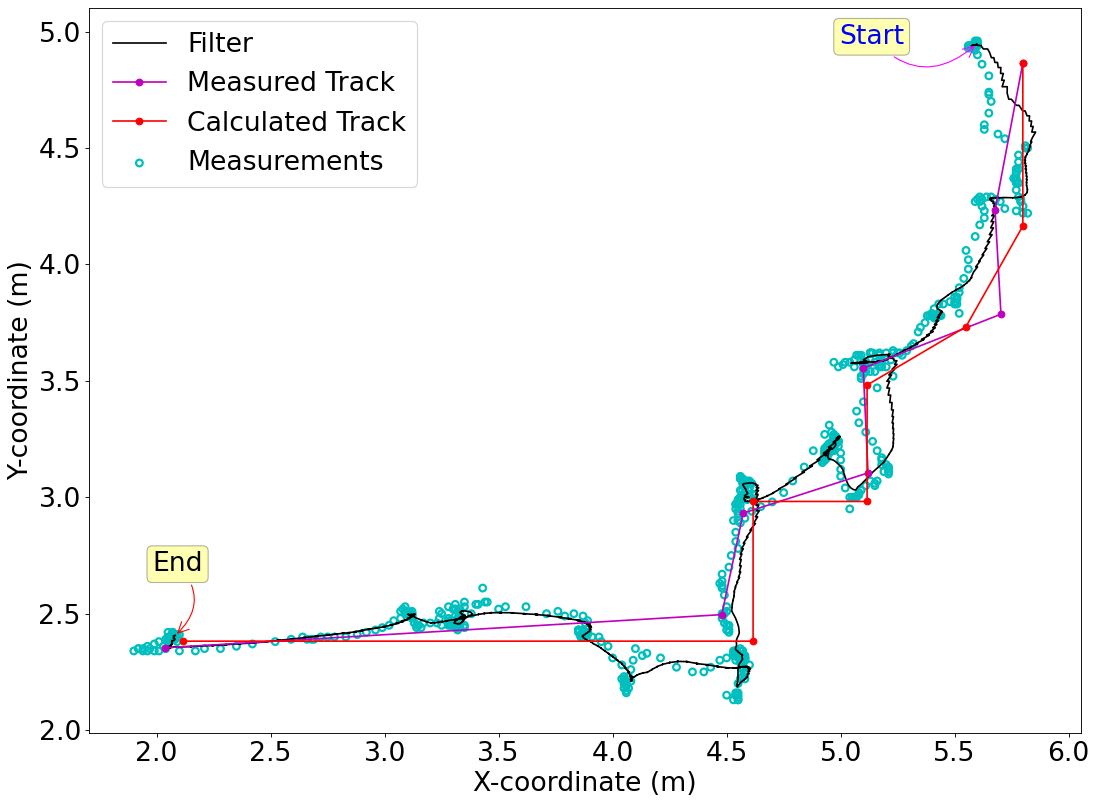

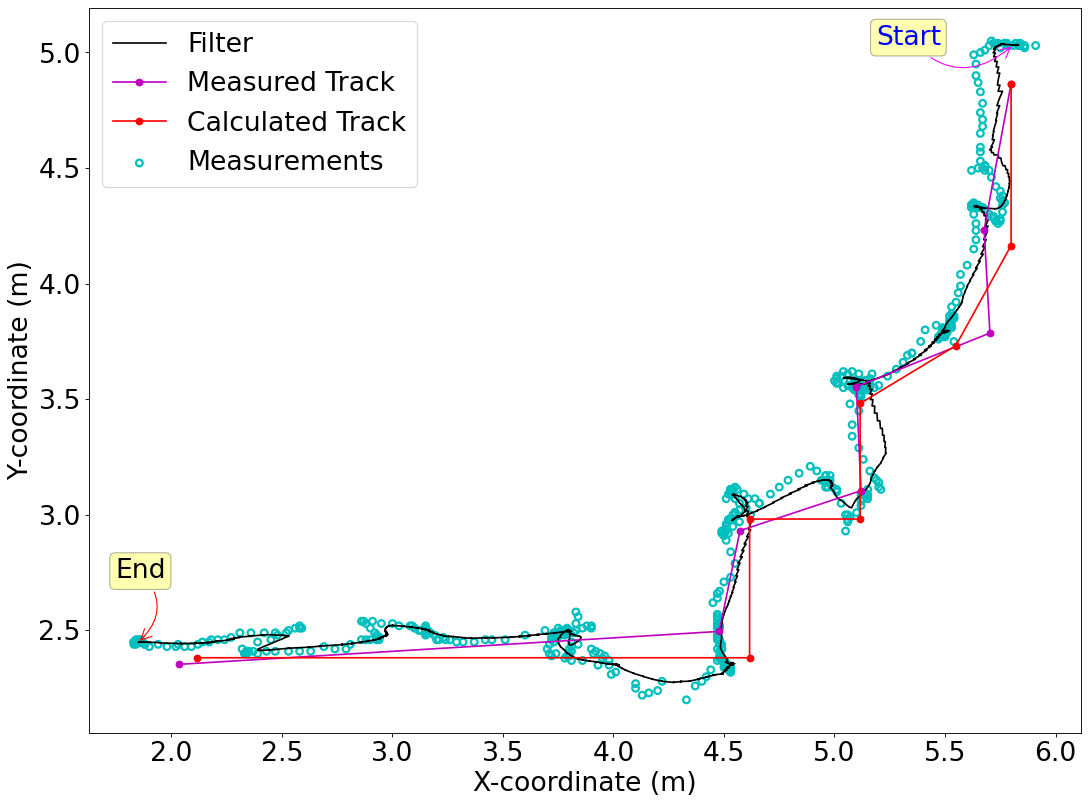

In [88]:
# generate plot for all experiments
for i in range(1, 11):    
    generate1(i)

In [91]:
print(f"mean = {np.mean(error)} m, variance = {statistics.variance(error)} m\u00b2")

mean = 0.2780208156858064 m, variance = 0.1045618158517677 m²
